In [41]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

Reads 3 datasets: pure Jurkat cells, pure 293T, and a 50:50 mix of both. Concats them together and proceeds with standard Seurat preprocessing steps.
Dataset comes from: [Zheng et al, “Massively parallel digital transcriptional profiling of single cells”](http://www.nature.com/articles/ncomms14049).
Analysis tries to reproduce the methods used in: https://www.nature.com/articles/s41592-019-0619-0

In [39]:
jurkat = sc.read_10x_mtx(
    'data/jurkat_raw_gene/hg19/',  
    var_names='gene_symbols',
    cache=True)
jurkat_293t = sc.read_10x_mtx(
    'data/jurkat_293t_50_50_raw_gene/hg19/',  
    var_names='gene_symbols',
    cache=True)
t293 = sc.read_10x_mtx(
    'data/293t_raw_gene/hg19/',  
    var_names='gene_symbols',
    cache=True)


In [47]:
adatas = {
    "jurkat": jurkat,
    "jurkat_293t": jurkat_293t,
    "293t": t293
}
adata = ad.concat(adatas, label="dataset")
adata.obs_names_make_unique()

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [48]:
adata

AnnData object with n_obs × n_vars = 2211840 × 32738
    obs: 'dataset'

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


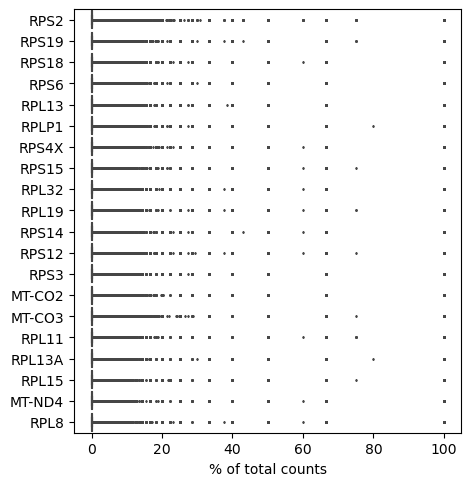

In [49]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [50]:
sc.pp.filter_cells(adata, min_genes=500)

In [51]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

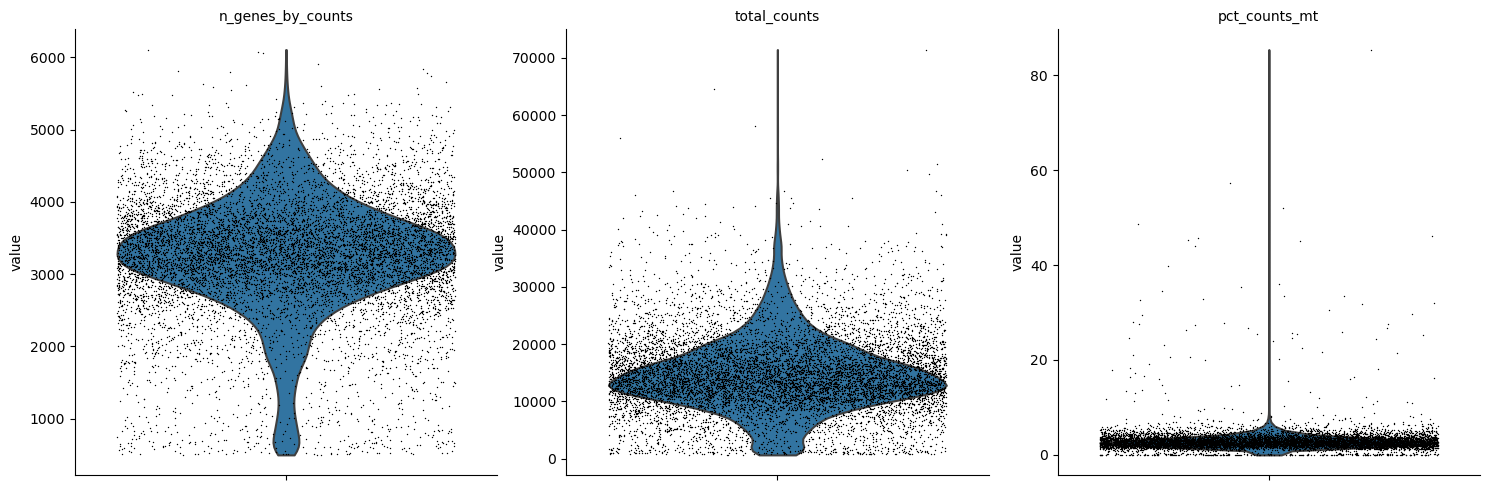

In [52]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [53]:
adata = adata[adata.obs.pct_counts_mt <= 20, :]

In [54]:
sc.pp.normalize_total(adata, target_sum=1e4)

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [55]:
sc.pp.log1p(adata)

In [69]:
adata

AnnData object with n_obs × n_vars = 9913 × 1000
    obs: 'dataset', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dataset_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [57]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

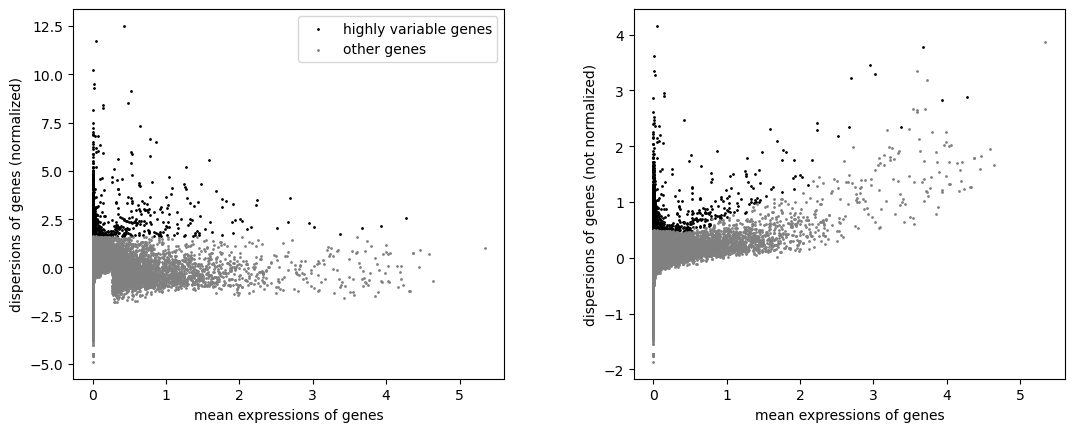

In [58]:
sc.pl.highly_variable_genes(adata)

In [59]:
adata.raw = adata

In [60]:
adata.var.highly_variable

MIR1302-10      False
FAM138A         False
OR4F5           False
RP11-34P13.7    False
RP11-34P13.8    False
                ...  
AC145205.1      False
BAGE5           False
CU459201.1      False
AC002321.2      False
AC002321.1      False
Name: highly_variable, Length: 32738, dtype: bool

In [61]:
adata = adata[:, adata.var.highly_variable]

In [62]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

In [63]:
sc.tl.pca(adata, svd_solver='arpack')

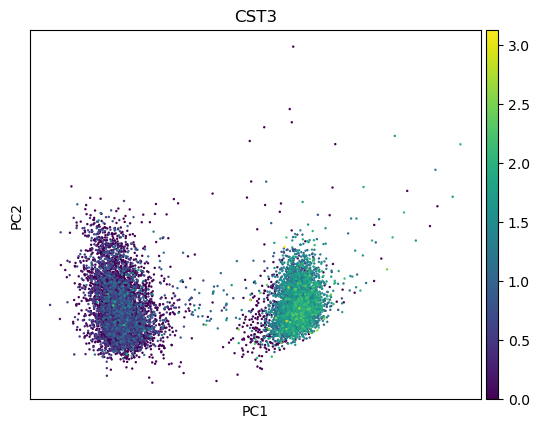

In [64]:
sc.pl.pca(adata, color='CST3')

In [65]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [66]:
sc.tl.umap(adata)

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


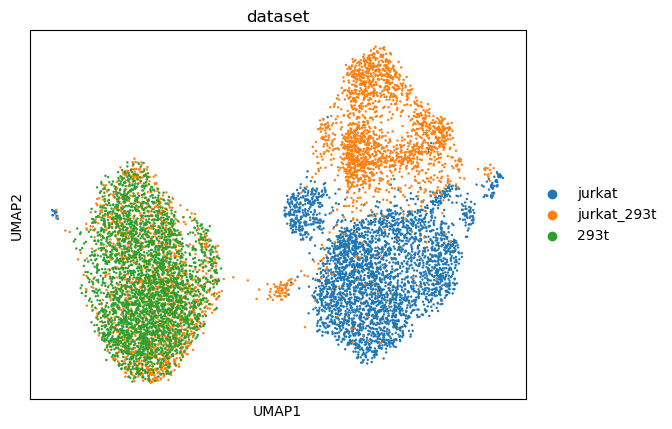

In [68]:
sc.pl.umap(adata, color=['dataset'])